<a href="https://colab.research.google.com/github/nandyc/rag_advanced/blob/main/advanced_rag.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/nandyc/rag_advanced.git

Cloning into 'rag_advanced'...
remote: Enumerating objects: 19, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 19 (delta 4), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (19/19), 2.06 MiB | 9.13 MiB/s, done.
Resolving deltas: 100% (4/4), done.


In [2]:
%cd rag_advanced

/content/rag_advanced


In [3]:
%%capture
# !pip install python-dotenv
!pip install openai
!pip install chromadb
!pip install tiktoken
!pip install pypdf
!pip install umap-learn
!pip install langchain
!pip install sentence-transformers

In [4]:
# #helper_utils.py
# # helper_utils.py
# import numpy as np
# import chromadb
# import pandas as pd
# from pypdf import PdfReader
# import numpy as np


# def project_embeddings(embeddings, umap_transform):
#     """
#     Projects the given embeddings using the provided UMAP transformer.

#     Args:
#     embeddings (numpy.ndarray): The embeddings to project.
#     umap_transform (umap.UMAP): The trained UMAP transformer.

#     Returns:
#     numpy.ndarray: The projected embeddings.
#     """
#     projected_embeddings = umap_transform.transform(embeddings)
#     return projected_embeddings


# def word_wrap(text, width=87):
#     """
#     Wraps the given text to the specified width.

#     Args:
#     text (str): The text to wrap.
#     width (int): The width to wrap the text to.

#     Returns:
#     str: The wrapped text.
#     """
#     return "\n".join([text[i : i + width] for i in range(0, len(text), width)])


# def extract_text_from_pdf(file_path):
#     """
#     Extracts text from a PDF file.

#     Args:
#     file_path (str): The path to the PDF file.

#     Returns:
#     str: The extracted text.
#     """
#     text = []
#     with open(file_path, "rb") as f:
#         pdf = PdfReader(f)
#         for page_num in range(pdf.get_num_pages()):
#             page = pdf.get_page(page_num)
#             text.append(page.extract_text())
#     return "\n".join(text)


# def load_chroma(filename, collection_name, embedding_function):
#     """
#     Loads a document from a PDF, extracts text, generates embeddings, and stores it in a Chroma collection.

#     Args:
#     filename (str): The path to the PDF file.
#     collection_name (str): The name of the Chroma collection.
#     embedding_function (callable): A function to generate embeddings.

#     Returns:
#     chroma.Collection: The Chroma collection with the document embeddings.
#     """
#     # Extract text from the PDF
#     text = extract_text_from_pdf(filename)

#     # Split text into paragraphs or chunks
#     paragraphs = text.split("\n\n")

#     # Generate embeddings for each chunk
#     embeddings = [embedding_function(paragraph) for paragraph in paragraphs]

#     # Create a DataFrame to store text and embeddings
#     data = {"text": paragraphs, "embeddings": embeddings}
#     df = pd.DataFrame(data)

#     # Create or load the Chroma collection

#     collection = chromadb.Client().create_collection(collection_name)

#     # Add the data to the Chroma collection
#     for ids, row in df.iterrows():

#         collection.add(ids=ids, documents=row["text"], embeddings=row["embeddings"])
#         # collection.add(text=row["text"], embedding=row["embeddings"])

#     return collection

In [5]:
import os
import collections
# from dotenv import load_dotenv
from openai import OpenAI
import chromadb
from chromadb.utils import embedding_functions
from google.colab import userdata


In [6]:
openai_key =userdata.get('OPENAI_APIKEY')

In [7]:
from helper_utils import project_embeddings, word_wrap
from pypdf import PdfReader
import os
from openai import OpenAI
from dotenv import load_dotenv

from pypdf import PdfReader
import umap

In [8]:
reader = PdfReader("data/microsoft-annual-report.pdf")
pdf_texts = [p.extract_text().strip() for p in reader.pages]

In [9]:
# Filter the empty strings
pdf_texts = [text for text in pdf_texts if text]
print(
    word_wrap(
        pdf_texts[0],
        width=100,
    )
)



Dear shareholders, colleagues, customers, and partners,  We are living through a time of historic ch
allenge and opportunity. As I write this, the world faces ongoing economic, social, and geopolitical
 volatility. At the same time, we have entered a new age of AI that will fundamentally transform pro
ductivity for every individual, organization, and industry on earth, and help us address some of our
 most pressing challenges.  This next generation of AI will reshape every software category and ever
y business, including our own. Forty-eight years after its founding, Microsoft remains a consequenti
al company because time and time again—from PC/Server, to Web/Internet, to Cloud/Mobile—we have adap
ted to technological paradigm shifts. Today, we are doing so once again, as we lead this new era.  A
mid this transformation, our mission to empower every person and every organization on the planet to
 achieve more remains constant. As a company, we believe we can be the democratizing force 

In [10]:
# split the text into smaller chunks

In [11]:
print(len(pdf_texts))

115


In [12]:
from langchain.text_splitter import (
    RecursiveCharacterTextSplitter,
    SentenceTransformersTokenTextSplitter,
)

In [13]:
character_splitter = RecursiveCharacterTextSplitter(
    separators=["\n\n", "\n", ". ", " ", ""], chunk_size=1000, chunk_overlap=0
)
character_split_texts = character_splitter.split_text("\n\n".join(pdf_texts))

In [14]:
print(word_wrap(character_split_texts[10]))
print(f"\nTotal chunks: {len(character_split_texts)}")

. In fact, our own support agents are using Copilot in Dynamics 365 Customer Service to
 resolve more cases faster and without having to call on peers to help. With our Supply
 Chain Platform, we’re helping customers apply AI to predict and mitigate disruptions. 
And, with our new Microsoft Sales Copilot, sellers can infuse their customer interactio
ns with data from CRM systems—including both Salesforce and Dynamics—to close more deal
s.  All up, Dynamics surpassed $5 billion in revenue over the past fiscal year, with ou
r customer experience, service, and finance and supply chain businesses each surpassing
 $1 billion in annual sales.  2

Total chunks: 410


In [15]:
token_splitter = SentenceTransformersTokenTextSplitter(
    chunk_overlap=0, tokens_per_chunk=256
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [16]:
token_split_texts = []
for text in character_split_texts:
    token_split_texts += token_splitter.split_text(text)

In [17]:
print(word_wrap(token_split_texts[10]))
print(f"\nTotal chunks: {len(token_split_texts)}")

. in fact, our own support agents are using copilot in dynamics 365 customer service to
 resolve more cases faster and without having to call on peers to help. with our supply
 chain platform, we ’ re helping customers apply ai to predict and mitigate disruptions
. and, with our new microsoft sales copilot, sellers can infuse their customer interact
ions with data from crm systems — including both salesforce and dynamics — to close mor
e deals. all up, dynamics surpassed $ 5 billion in revenue over the past fiscal year, w
ith our customer experience, service, and finance and supply chain businesses each surp
assing $ 1 billion in annual sales. 2

Total chunks: 419


In [18]:
import chromadb
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction

In [19]:
embedding_function = SentenceTransformerEmbeddingFunction()
print(embedding_function([token_split_texts[10]]))

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

[[-0.09653973579406738, -0.04158387705683708, -0.012433700263500214, -0.04179719090461731, -0.030539317056536674, 0.027540603652596474, 0.04011613130569458, 0.023341378197073936, 0.023385249078273773, -0.019350748509168625, -0.004833717364817858, 0.060317542403936386, 0.008077798411250114, 0.014494276605546474, 0.06857570260763168, 0.03740416467189789, 0.05008044093847275, -0.11688182502985, -0.03645576909184456, -0.06126472353935242, -0.059768084436655045, -0.020975371822714806, -0.09125791490077972, 0.009967302903532982, -0.061085183173418045, -0.0005210776580497622, -0.04857518523931503, 0.0019512515282258391, -0.01667380891740322, -0.020581936463713646, -0.05197266489267349, 0.017281388863921165, 0.09175770729780197, 0.057938944548368454, -0.005578440148383379, -0.03116043098270893, -0.0015127694932743907, 0.0066135721281170845, 0.07161945104598999, -0.028821082785725594, 0.033757880330085754, -0.0024867597967386246, -0.07723861932754517, 0.004433584865182638, 0.09457170963287354, 

In [20]:
chroma_client = chromadb.Client()
chroma_collection = chroma_client.create_collection(
    "microsoft-collection", embedding_function=embedding_function
)

In [31]:
# extract the embeddings of the token_split_texts
ids = [str(i) for i in range(len(token_split_texts))]
chroma_collection.add(ids=ids, documents=token_split_texts)
count = chroma_collection.count()

print(f"Total documents in the collection: {count}")

Total documents in the collection: 419


In [22]:
query = "What was the total revenue for the year?"

In [23]:
results = chroma_collection.query(query_texts=[query], n_results=5)
retrieved_documents = results["documents"][0]

In [24]:
for document in retrieved_documents:
    print(word_wrap(document))
    print("\n")

income taxes 4, 152 4, 067 short - term unearned revenue 50, 901 45, 538 other current 
liabilities 14, 745 13, 067


segment revenue and operating income were as follows during the periods presented : no 
sales to an individual customer or country other than the united states accounted for m
ore than 10 % of revenue for fiscal years 2023, 2022, or 2021. revenue, classified by t
he major geographic areas in which our customers were located, was as follows : ( a ) i
ncludes billings to oems and certain multinational organizations because of the nature 
of these businesses and the impracticability of determining the geographic source of th
e revenue. ( in millions ) year ended june 30, 202320222021 revenue productivity and bu
siness processes $ 69, 274 $ 63, 364 $ 53, 915 intelligent cloud 87, 907 74, 965 59, 72
8 more personal computing 54, 734 59, 941 54, 445 total $ 211, 915 $ 198, 270 $ 168, 08
8 operating income


revenue, classified by significant product and service offerings, was

In [25]:
client = OpenAI(api_key=openai_key)

In [26]:
def augment_query_generated(query, model="gpt-3.5-turbo"):
    prompt = """You are a helpful expert financial research assistant.
   Provide an example answer to the given question, that might be found in a document like an annual report."""
    messages = [
        {
            "role": "system",
            "content": prompt,
        },
        {"role": "user", "content": query},
    ]

    response = client.chat.completions.create(
        model=model,
        messages=messages,
    )
    content = response.choices[0].message.content
    return content

In [27]:
original_query = "What was the total profit for the year, and how does it compare to the previous year?"
hypothetical_answer = augment_query_generated(original_query)

In [28]:
joint_query = f"{original_query} {hypothetical_answer}"
print(word_wrap(joint_query))

What was the total profit for the year, and how does it compare to the previous year? I
n the current fiscal year, the company recorded a total profit of $10 million. This rep
resents a significant increase compared to the previous year, where the total profit wa
s $8 million. The year-over-year profit growth of 25% demonstrates the success of our s
trategic initiatives and effective cost management practices.


In [29]:
results = chroma_collection.query(
    query_texts=joint_query, n_results=5, include=["documents", "embeddings"]
)
retrieved_documents = results["documents"][0]

In [30]:
for doc in retrieved_documents:
    print(word_wrap(doc))
    print("")

revenue $ 211, 915 $ 198, 270 7 % gross margin 146, 052 135, 620 8 % operating income 8
8, 523 83, 383 6 % net income 72, 361 72, 738 ( 1 ) % diluted earnings per share 9. 68 
9. 65 0 % adjusted gross margin ( non - gaap ) 146, 204 135, 620 8 % adjusted operating
 income ( non - gaap ) 89, 694 83, 383 8 % adjusted net income ( non - gaap ) 73, 307 6
9, 447 6 % adjusted diluted earnings per share ( non - gaap ) 9. 81 9. 21 7 % 31

research and development $ 27, 195 $ 24, 512 11 % as a percent of revenue 13 % 12 % 1pp
t ( in millions, except percentages ) 20232022percentage change sales and marketing $ 2
2, 759 $ 21, 825 4 % as a percent of revenue 11 % 11 % 0ppt ( in millions, except perce
ntages ) 20232022percentage change general and administrative $ 7, 575 $ 5, 900 28 % as
 a percent of revenue 4 % 3 % 1ppt 35

. • gross margin increased $ 5. 8 billion or 12 % driven by growth in office 365 commer
cial and linkedin, as well as the change in accounting estimate. gross margin percentag

In [32]:
embeddings = chroma_collection.get(include=["embeddings"])["embeddings"]
umap_transform = umap.UMAP(random_state=0, transform_seed=0).fit(embeddings)
projected_dataset_embeddings = project_embeddings(embeddings, umap_transform)

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [33]:
retrieved_embeddings = results["embeddings"][0]
original_query_embedding = embedding_function([original_query])
augmented_query_embedding = embedding_function([joint_query])

In [34]:
projected_original_query_embedding = project_embeddings(
    original_query_embedding, umap_transform
)
projected_augmented_query_embedding = project_embeddings(
    augmented_query_embedding, umap_transform
)
projected_retrieved_embeddings = project_embeddings(
    retrieved_embeddings, umap_transform
)


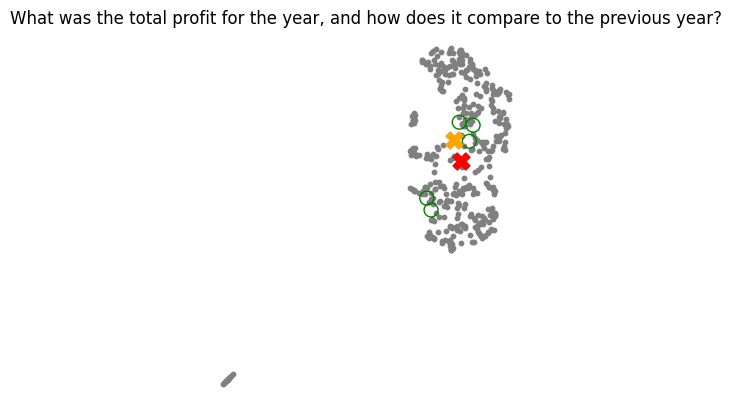

In [35]:
import matplotlib.pyplot as plt

# Plot the projected query and retrieved documents in the embedding space
plt.figure()

plt.scatter(
    projected_dataset_embeddings[:, 0],
    projected_dataset_embeddings[:, 1],
    s=10,
    color="gray",
)
plt.scatter(
    projected_retrieved_embeddings[:, 0],
    projected_retrieved_embeddings[:, 1],
    s=100,
    facecolors="none",
    edgecolors="g",
)
plt.scatter(
    projected_original_query_embedding[:, 0],
    projected_original_query_embedding[:, 1],
    s=150,
    marker="X",
    color="r",
)
plt.scatter(
    projected_augmented_query_embedding[:, 0],
    projected_augmented_query_embedding[:, 1],
    s=150,
    marker="X",
    color="orange",
)

plt.gca().set_aspect("equal", "datalim")
plt.title(f"{original_query}")
plt.axis("off")
plt.show()  # display the plot